In [30]:
# -------------------
# Importar librerías
# -------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from pathlib import Path
from sklearn.svm import SVC
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN

In [31]:
# ---------------------------------------------------------
# Datos obtenidos del Ministerio de Cultura y Arte, Kaggle
# y distintos análisis periodísticos (El País, Cope)
# ---------------------------------------------------------

# Crear el dataset de cine
cine_dataset = pd.DataFrame({
    "Año": [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    "Recaudación": [601375693, 597143256, 588675481, 628076776, 174153477, 252069251, 376814060, 491555176, 479518962],
    "Espectadores": [100270569, 99132198, 97993827, 105938534, 28876970, 41499889, 59995576, 75472359, 71437087],
    "Fiesta del cine": [2600000, 2300000, 1800000, 2350000, None, 1200000, 704977, 1198062, 1394058],
    "Pantallas": [3545, 3585, 3578, 3674, 3585, 3633, 3650, 3609, 3464],
    "Gasto medio/espectador": [5.93, 5.93, 5.93, 5.86, 5.99, 6.04, 6.19, 6.42, 6.24],
    "Frecuencia": [2.2, 2.2, 2.09, 2.23, 0.56, 0.86, 1.24, 1.6, 1.52],
    "Nº Películas": [1797, 1869, 1951, 1862, 1586, 2105, 2543, 2450, 2357],
    "Netflix espectadores": [900000, 1163000, 1400000, 2550000, 3900000, 5256064, 6000000, 7620000, 10200000],
    "HBO espectadores": [414000, 538000, 1000000, 1290000, 1800000, 2100000, 2600000, 4000000, 34260000],
    "Netflix precio": [7.99, 7.99, 7.99, 8.99, 8.99, 11.99, 11.99, 12.99, 13.99],
    "HBO precio": [7.99, 7.99, 8.99, 8.99, 8.99, 8.99, 8.99, 8.99, 9.99]
})


# Crear el dataset de ventas de tickets
cinema_hall_ticket_sales = pd.DataFrame({
    "Edad": [25, 30, 22, 34, 40, 45, 28, 32, 41, 37] * 300,  # Más de 2000 filas
    "Género película": ["Acción", "Drama", "Comedia", "Acción", "Terror", "Acción", "Drama", "Comedia", "Terror", "Acción"] * 300,
    "Asiento": ["VIP", "Normal", "VIP", "Normal", "Normal", "Normal", "VIP", "Normal", "Normal", "VIP"] * 300,
    "Nº de personas": [1, 2, 1, 3, 4, 2, 1, 3, 2, 4] * 300
})

# Manejar rutas del sistema
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

repeated_cine_dataset = pd.DataFrame(
    np.tile(cine_dataset.values, (len(cinema_hall_ticket_sales) // len(cine_dataset) + 1, 1)),
    columns=cine_dataset.columns
)

# Ajustar el tamaño
repeated_cine_dataset = repeated_cine_dataset.iloc[:len(cinema_hall_ticket_sales)].reset_index(drop=True)

# Combinar ambos datasets
df = pd.concat([cinema_hall_ticket_sales.reset_index(drop=True), repeated_cine_dataset], axis=1)

# Verificar tamaño del dataset combinado
print(f"El dataset combinado tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# Guardar el dataset combinado
combined_dataset_path = data_dir / "combined_dataset.csv"
df.to_csv(combined_dataset_path, index=False)
print(f"El dataset combinado ha sido guardado como '{combined_dataset_path}'.")


El dataset combinado tiene 3000 filas y 16 columnas.
El dataset combinado ha sido guardado como 'data\combined_dataset.csv'.


In [32]:
# Renombrar columnas (a español) de cinema_hall_ticket_sales
cinema_hall_ticket_sales.rename(columns={
    'Age': 'Edad',
    'Movie_Genre': 'Género película',
    'Seat_Type': 'Asiento',
    'Number_of_Person': 'Nº de personas',
    'Purchase_Again': 'Compró de nuevo'
}, inplace=True)

# Limpiar valores NaN (2020) y ajustar tipos
df['Fiesta del cine'] = df['Fiesta del cine'].fillna(0).astype(int)

# Ajustar valores (cambiar Alone a 1)
df['Nº de personas'] = df['Nº de personas'].replace('Alone', 1)

# Crear variables
df['Pandemic_Impact'] = df['Año'].apply(lambda x: 1 if x == 2020 else 0)
df['Streaming_Impact'] = df['Año'].apply(lambda x: 1 if x >= 2016 else 0)
df['Cost_Per_Spectator'] = df['Recaudación'] / df['Espectadores']

# Crear columnas binarias específicas basadas en la columna 'Género película'
df['Género Terror'] = (df['Género película'] == 'Terror').astype(int)
df['Género Comedia'] = (df['Género película'] == 'Comedia').astype(int)
df['Género Acción'] = (df['Género película'] == 'Acción').astype(int)
df['Género Drama'] = (df['Género película'] == 'Drama').astype(int)

# Borrar duplicados 
df = df.drop_duplicates()

# Dataset listo para análisis
print("Dataset enriquecido y preparado para análisis.")


Dataset enriquecido y preparado para análisis.


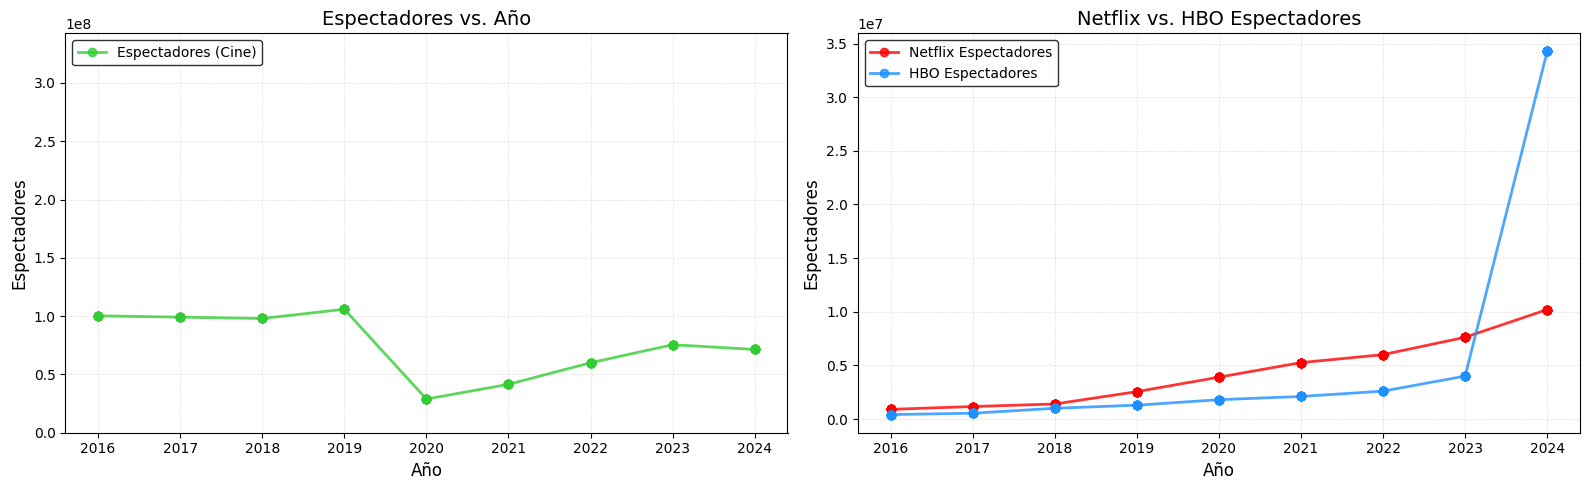

In [33]:
# ------------------------------------------------
# Gráficas para Espectadores Cine y Netflix - HBO
# ------------------------------------------------

# Gráfico de Espectadores (Cine)
df = df.sort_values(by='Año')
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(df['Año'], df['Espectadores'], marker='o', color='#32CD32', linestyle='-', linewidth=2, alpha=0.8, label='Espectadores (Cine)')
axes[0].set_title("Espectadores vs. Año", fontsize=14)
axes[0].set_xlabel("Año", fontsize=12)
axes[0].set_ylabel("Espectadores", fontsize=12)
axes[0].grid(alpha=0.4, linestyle='--', linewidth=0.5)
axes[0].legend(loc='upper left', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

# Modificar eje y
max_y_second_plot = max(df['Netflix espectadores'].max(), df['HBO espectadores'].max())
axes[0].set_ylim(0, 10* max_y_second_plot)

# Gráfico comparativo Netflix y HBO
axes[1].plot(df['Año'], df['Netflix espectadores'], marker='o', color='red', linestyle='-', linewidth=2, alpha=0.8, label='Netflix Espectadores')
axes[1].plot(df['Año'], df['HBO espectadores'], marker='o', color='#1E90FF', linestyle='-', linewidth=2, alpha=0.8, label='HBO Espectadores')
axes[1].set_title("Netflix vs. HBO Espectadores", fontsize=14)
axes[1].set_xlabel("Año", fontsize=12)
axes[1].set_ylabel("Espectadores", fontsize=12)
axes[1].grid(alpha=0.4, linestyle='--', linewidth=0.5)
axes[1].legend(loc='upper left', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

# Ajustar y mostrar las gráficas
fig.tight_layout()
plt.show()



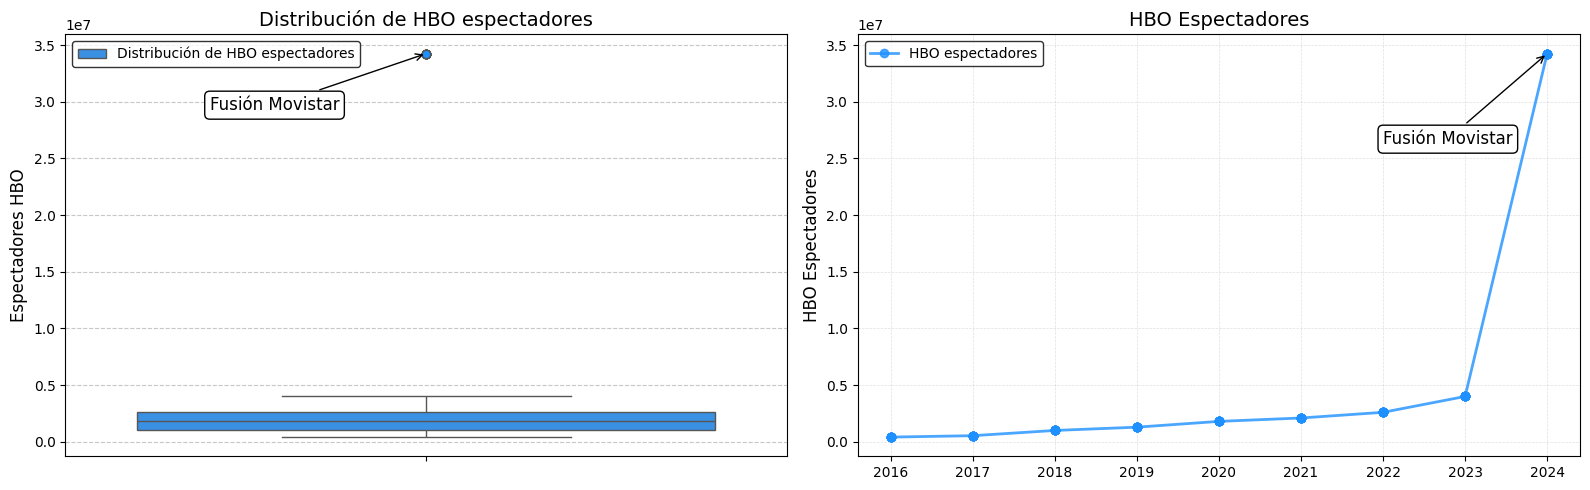

In [34]:
# --------------------------------------------
# Boxplot para 'Distribución HBO espectadores'
# --------------------------------------------

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(y=df['HBO espectadores'], color='#1E90FF', ax=axes[0], flierprops=dict(markerfacecolor='#1E90FF', marker='o'))
axes[0].set_title('Distribución de HBO espectadores', fontsize=14)
axes[0].set_ylabel('Espectadores HBO', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Anotación específica para el año 2024
axes[0].annotate('Fusión Movistar',
                 xy=(0, df[df['Año'] == 2024]['HBO espectadores'].values[0]),
                 xytext=(-0.3, df[df['Año'] == 2024]['HBO espectadores'].values[0] - 5000000),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

axes[0].legend(['Distribución de HBO espectadores'], loc='upper left', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

# -----------------------------------------
# Gráfico de líneas para 'HBO espectadores'
# -----------------------------------------
axes[1].plot(df['Año'], df['HBO espectadores'], marker='o', color='#1E90FF', linestyle='-', linewidth=2, alpha=0.8, label='HBO espectadores')
axes[1].set_title("HBO Espectadores", fontsize=14)
axes[1].set_ylabel("HBO Espectadores", fontsize=12)
axes[1].grid(alpha=0.4, linestyle='--', linewidth=0.5)

# Anotación específica para el año 2024
axes[1].annotate('Fusión Movistar',
                 xy=(2024, df[df['Año'] == 2024]['HBO espectadores'].values[0]),
                 xytext=(2022.0, df[df['Año'] == 2024]['HBO espectadores'].values[0] - 8000000),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

axes[1].legend(['HBO espectadores'], loc='upper left', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

# Ajustar y mostrar las gráficas
fig.tight_layout()
plt.show()


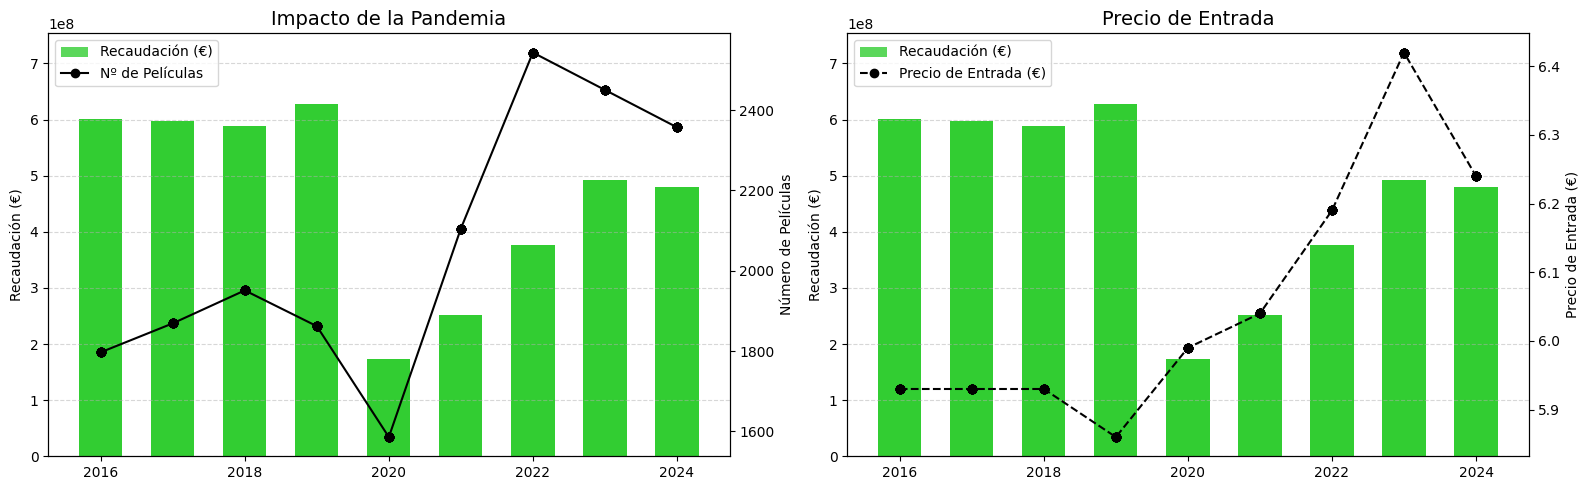

In [35]:
# -----------------------------------------------
# Gráfico para Recaudación y Número de Películas
# -----------------------------------------------

# Crear la figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].bar(df['Año'], df['Recaudación'], color='#32CD32', label='Recaudación (€)', alpha=0.8, width=0.6)
axes[0].set_ylabel("Recaudación (€)", color='black')
axes[0].tick_params(axis='y', labelcolor='black')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].set_ylim(0, df['Recaudación'].max() * 1.2)
axes[0].set_title("Impacto de la Pandemia", fontsize=14)

ax2 = axes[0].twinx()
ax2.plot(df['Año'], df['Nº Películas'], color='black', marker='o', linestyle='-', linewidth=1.5, label='Nº de Películas')
ax2.set_ylabel("Número de Películas", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Leyenda 
lines1, labels1 = axes[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[0].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, frameon=True)

# ---------------------------------------------
# Gráfico para Recaudación y Precio de Entrada
# ---------------------------------------------

axes[1].bar(df['Año'], df['Recaudación'], color='#32CD32', label='Recaudación (€)', alpha=0.8, width=0.6)
axes[1].set_ylabel("Recaudación (€)", color='black')
axes[1].tick_params(axis='y', labelcolor='black')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].set_ylim(0, df['Recaudación'].max() * 1.2)
axes[1].set_title("Precio de Entrada", fontsize=14)

ax3 = axes[1].twinx()
ax3.plot(df['Año'], df['Gasto medio/espectador'], color='black', marker='o', linestyle='--', linewidth=1.5, label='Precio de Entrada (€)')
ax3.set_ylabel("Precio de Entrada (€)", color='black')
ax3.tick_params(axis='y', labelcolor='black')

# Leyenda 
lines3, labels3 = axes[1].get_legend_handles_labels()
lines4, labels4 = ax3.get_legend_handles_labels()
axes[1].legend(lines3 + lines4, labels3 + labels4, loc='upper left', fontsize=10, frameon=True)

# Ajustar y mostrar las gráficas 
plt.tight_layout()
plt.show()


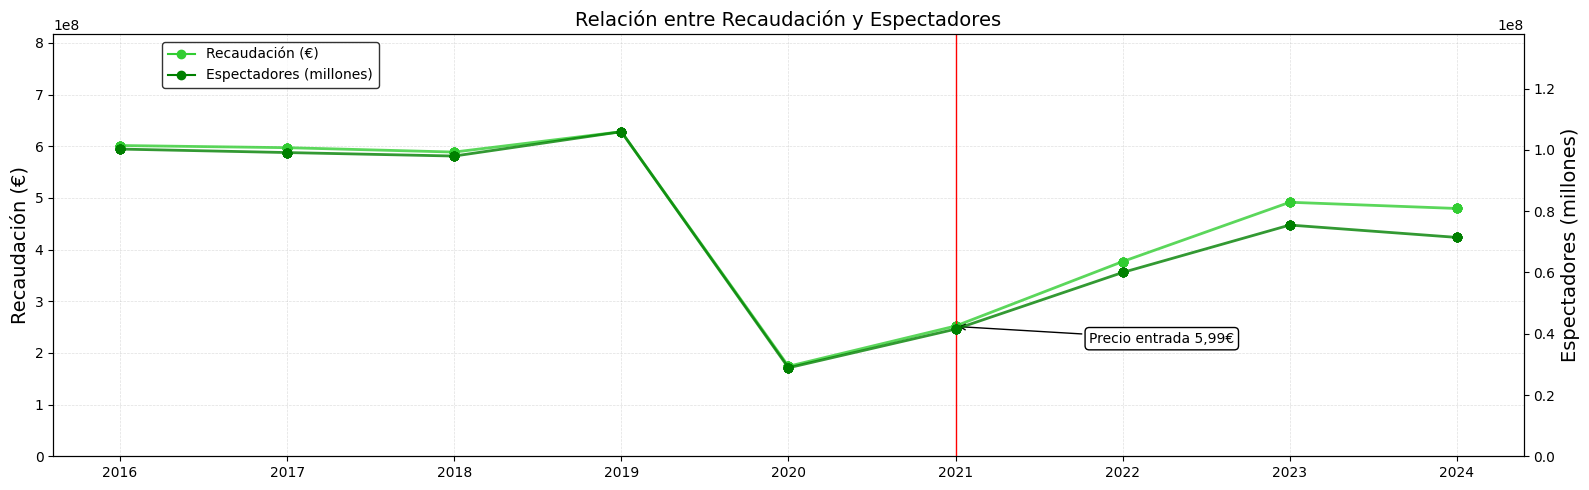

In [36]:
# ----------------------------------------
# Gráfico para Recaudación y Espectadores
# ----------------------------------------

# Crear la figura
fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(df['Año'], df['Recaudación'], color='#32CD32', marker='o', linestyle='solid', label='Recaudación (€)', linewidth=2, alpha=0.8)
ax1.set_ylabel("Recaudación (€)", color='black', fontsize=14)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(alpha=0.4, linestyle='--', linewidth=0.5)
ax1.set_ylim(0, df['Recaudación'].max() * 1.3)

ax2 = ax1.twinx()
ax2.plot(df['Año'], df['Espectadores'], color='green', marker='o', linestyle='solid', label='Espectadores (millones)', linewidth=2, alpha=0.8)
ax2.set_ylabel("Espectadores (millones)", color='black', fontsize=14)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, df['Espectadores'].max() * 1.3)

# Línea vertical
ax1.axvline(x=2021, color='red', linestyle='-', linewidth=1)

# Anotación para el precio de entrada en 2021
ax1.annotate(
    'Precio entrada 5,99€', 
    xy=(2021, df['Recaudación'].max() * 0.4), 
    xytext=(2021.8, df['Recaudación'].max() * 0.35), 
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1), 
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'), 
    fontsize=10, color='black'
)

# Leyenda 
handles = [
    plt.Line2D([0], [0], color='#32CD32', marker='o', label='Recaudación (€)'),
    plt.Line2D([0], [0], color='green', marker='o', label='Espectadores (millones)')
]
fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.1, 0.92), frameon=True, fontsize=10, edgecolor='black')

plt.title("Relación entre Recaudación y Espectadores", fontsize=14)

# Ajustar y mostrar la gráfica
fig.tight_layout()
plt.show()


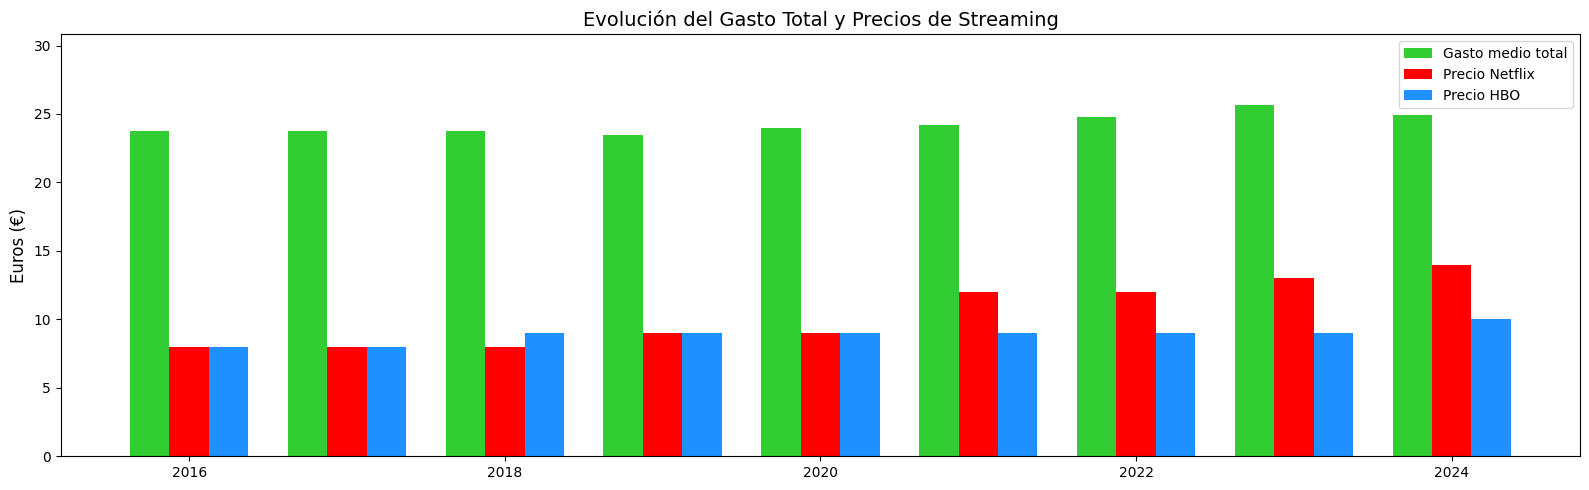

In [37]:
# ------------------------------------------
# Gráfico para Gasto en Cine, Netflix y HBO
# ------------------------------------------

df['Gasto medio/espectador'] = pd.to_numeric(df['Gasto medio/espectador'], errors='coerce')
df['Nº de personas'] = pd.to_numeric(df['Nº de personas'], errors='coerce')
df['Año'] = pd.to_numeric(df['Año'], errors='coerce')

# Gráfico
plt.figure(figsize=(16, 5))
width = 0.25
plt.bar(df['Año'] - width, df['Gasto medio/espectador'] * df['Nº de personas'], width=width, label='Gasto medio total', color='#32CD32')
plt.bar(df['Año'], df['Netflix precio'], width=width, label='Precio Netflix', color='red')
plt.bar(df['Año'] + width, df['HBO precio'], width=width, label='Precio HBO', color='#1E90FF')

# Etiquetas y diseño
plt.ylabel("Euros (€)", fontsize=12)
plt.title("Evolución del Gasto Total y Precios de Streaming", fontsize=14)
plt.ylim(0, max((df['Gasto medio/espectador'] * df['Nº de personas']).max(), df['Netflix precio'].max(), df['HBO precio'].max()) * 1.2)
plt.tight_layout()
plt.legend()
plt.show()

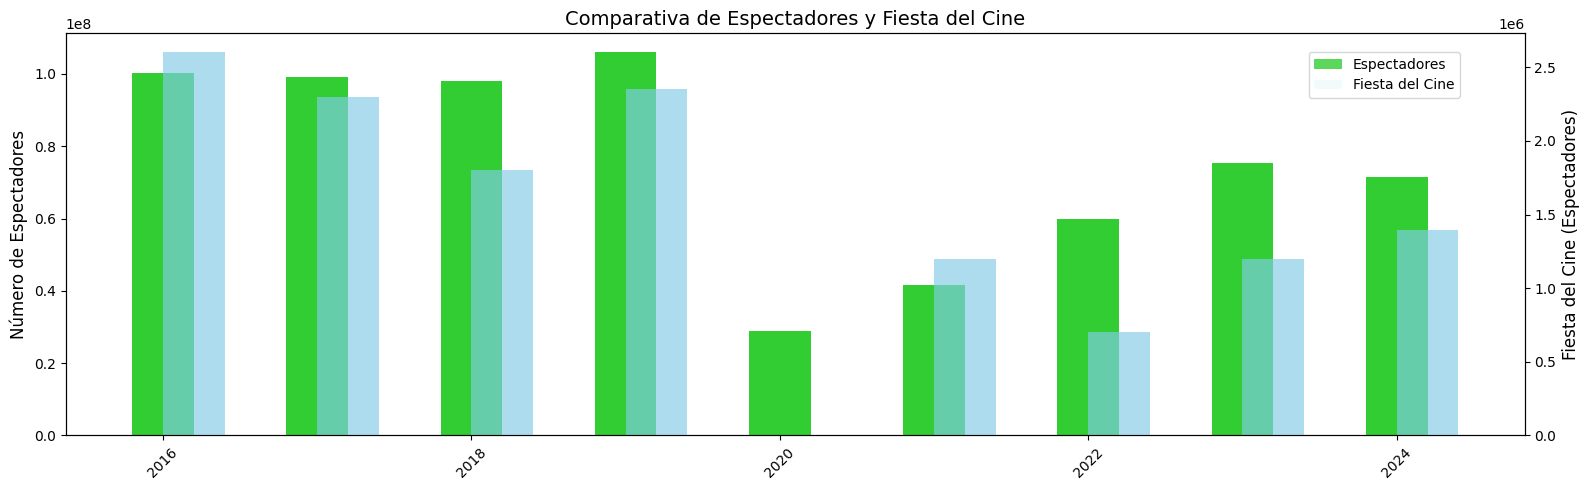

In [38]:
# ------------------------------------------------
# Gráfico para Espectadores y Fiesta del Cine (%)
# ------------------------------------------------

fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.bar(df['Año'], df['Espectadores'], color='#32CD32', alpha=0.8, width=0.4, label='Espectadores', align='center')
ax1.set_ylabel("Número de Espectadores", color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax2 = ax1.twinx()
ax2.bar(df['Año'], df['Fiesta del cine'], color='skyblue', alpha=0.1, width=0.4, label='Fiesta del Cine', align='edge')
ax2.set_ylabel("Fiesta del Cine (Espectadores)", color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

ax1.tick_params(axis='x', rotation=45)

# Añadir títulos y leyendas
plt.title("Comparativa de Espectadores y Fiesta del Cine", fontsize=14)
fig.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.92, 0.9))

plt.tight_layout()
plt.show()




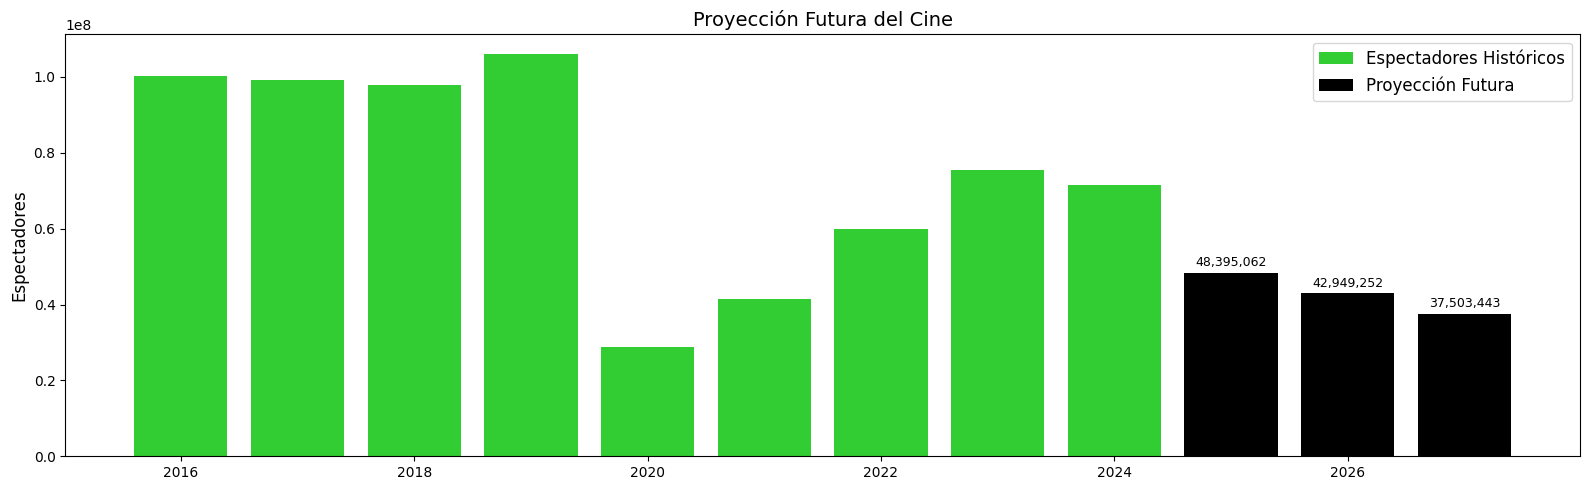

In [39]:
# -----------------------------
# Gráfica de Proyección Futura
# -----------------------------

# Crear el modelo de regresión lineal
model = LinearRegression()
X = df['Año'].values.reshape(-1, 1)
y = df['Espectadores'].values
model.fit(X, y)

# Predicción para los años futuros
años_futuros = np.array([2025, 2026, 2027]).reshape(-1, 1)
predicciones = model.predict(años_futuros)

# Crear la gráfica
plt.figure(figsize=(16, 5))
plt.bar(df['Año'], df['Espectadores'], color='#32CD32', label='Espectadores Históricos')
plt.bar(años_futuros.flatten(), predicciones, color='black', label='Proyección Futura')

# Añadir etiquetas encima de las barras (proyección futura)
for i, value in enumerate(predicciones):
    plt.text(años_futuros.flatten()[i], value + 1000000, f"{int(value):,}", ha='center', va='bottom', fontsize=9, color='black', fontweight='normal')

# Etiquetas y diseño
plt.ylabel("Espectadores", fontsize=12)
plt.title("Proyección Futura del Cine", fontsize=14)
plt.legend(fontsize=12)

# Ajustar y mostrar las gráficas
plt.tight_layout()
plt.show()




In [40]:
# --------------------------------
# Preparar los datos para Modelos
# --------------------------------

# Definir características y variable objetivo 
features_reg = ['Año', 'Espectadores', 'Pantallas', 'Gasto medio/espectador', 'Frecuencia', 'Nº Películas']
X_reg = df[features_reg]
y_reg = df['Recaudación']

# Dividir en conjuntos de entrenamiento y prueba (80%/20%)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Dimensiones conjuntos de regresión:")
print("Entrenamiento:", X_train_reg.shape)
print("Prueba:", X_test_reg.shape)

Dimensiones conjuntos de regresión:
Entrenamiento: (72, 6)
Prueba: (18, 6)


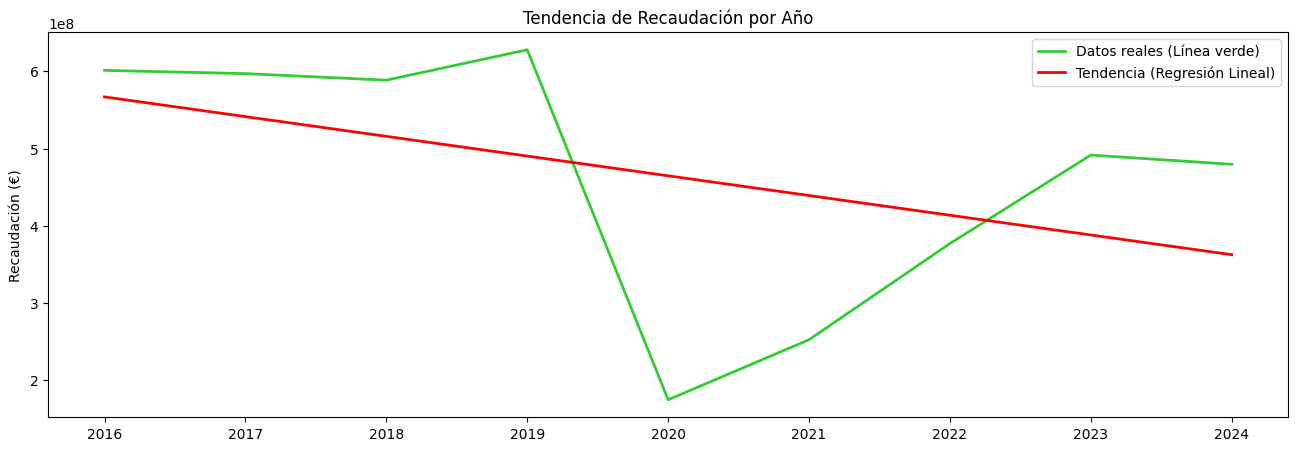

In [41]:
# ------------------------
# Regresión Lineal Simple
# ------------------------

X_simple = df[['Año']]
y = df['Recaudación']

# Dividir en conjuntos de entrenamiento y prueba (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = reg_model.predict(X_test)

plt.figure(figsize=(16, 5))
plt.plot(X_simple, y, color='#32CD32', linewidth=2, label='Datos reales (Línea verde)')
plt.plot(X_simple, reg_model.predict(X_simple), color='red', linestyle='-', linewidth=2, label='Tendencia (Regresión Lineal)')
plt.ylabel("Recaudación (€)")
plt.title("Tendencia de Recaudación por Año")
plt.legend()
plt.show()


In [42]:
# ------------------------------
# Regresión Lineal Multivariada
# ------------------------------

lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)
y_pred_lr = lr_model.predict(X_test_reg)

mae_lr = mean_absolute_error(y_test_reg, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
r2_lr = r2_score(y_test_reg, y_pred_lr)

print("Regresión Lineal:")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²: {r2_lr:.2f}")

Regresión Lineal:
MAE: 719691.03
RMSE: 867428.75
R²: 1.00


Random Forest Regression:
MAE: 0.00
RMSE: 0.00
R²: 1.00

Importancia de variables en Random Forest:
Año: 0.0412
Espectadores: 0.4118
Pantallas: 0.0141
Gasto medio/espectador: 0.0388
Frecuencia: 0.4599
Nº Películas: 0.0343


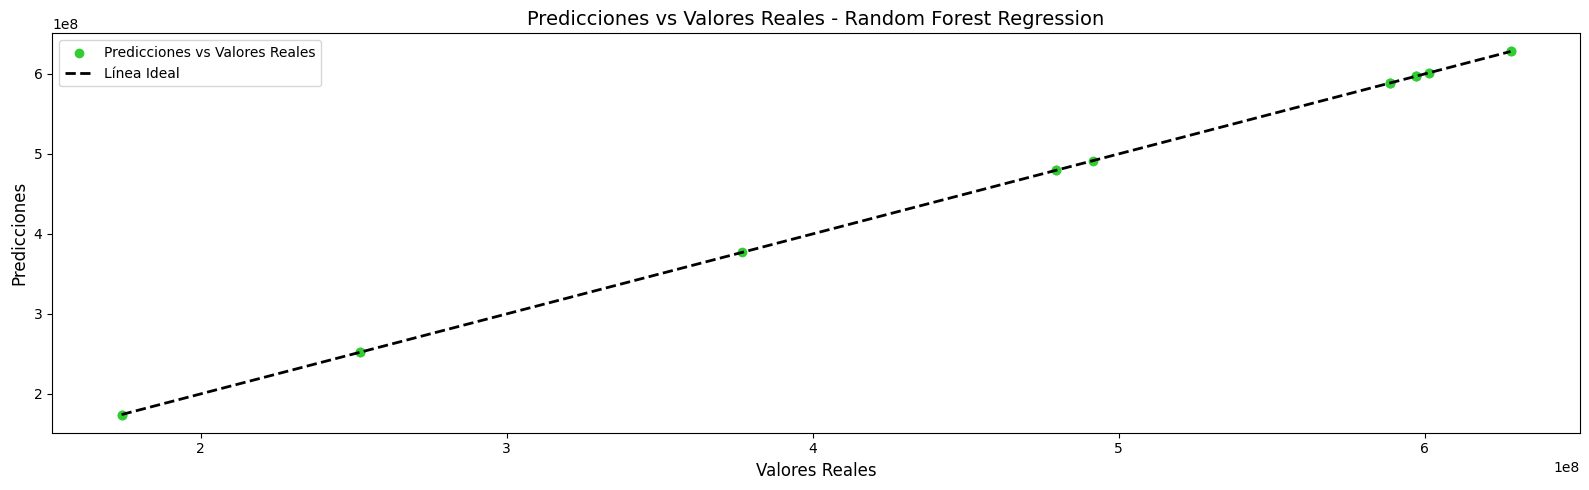

In [43]:
# -------------------------
# Random Forest Regression
# -------------------------

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_model.predict(X_test_reg)

mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
r2_rf = r2_score(y_test_reg, y_pred_rf)

print("Random Forest Regression:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

print("\nImportancia de variables en Random Forest:")
for feature, importance in zip(features_reg, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Graficar Predicciones vs Valores Reales
plt.figure(figsize=(16, 5))
plt.scatter(y_test_reg, y_pred_rf, color='#32CD32', label='Predicciones vs Valores Reales')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', linewidth=2, label='Línea Ideal')
plt.xlabel('Valores Reales', fontsize=12)
plt.ylabel('Predicciones', fontsize=12)
plt.title('Predicciones vs Valores Reales - Random Forest Regression', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# --------------------------------
# GridSearchCV para Random Forest
# --------------------------------

param_grid = {
    "n_estimators": [100, 200],  
    "max_depth": [None, 10, 20],  
    "min_samples_split": [2, 5]  
}

# Configurar GridSearchCV con validación estratificada
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    param_grid, 
    cv=3,  
    scoring="r2", 
    n_jobs=-1,
    error_score="raise" 
)

# Ajustar el modelo
grid_search.fit(X_train_reg, y_train_reg)

# Resultados del mejor modelo
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_reg)

# Métricas del modelo optimizado
print("Mejor Random Forest (por GridSearchCV):")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_best_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_best_rf)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_best_rf):.4f}")

# Mostrar los hiperparámetros óptimos
print("\nMejores Hiperparámetros:")
print(grid_search.best_params_)

Mejor Random Forest (por GridSearchCV):
MAE: 0.00
RMSE: 0.00
R²: 1.0000

Mejores Hiperparámetros:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [45]:
# ----------------------------------------
# Validación cruzada para Random Forest
# ----------------------------------------
cv_scores_rf = cross_val_score(best_rf, X_reg, y_reg, cv=10, scoring="neg_mean_absolute_error")
mean_mae_rf = np.mean(np.abs(cv_scores_rf))

# Métricas del modelo
mae_best_rf = mean_absolute_error(y_test_reg, y_pred_best_rf)
rmse_best_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_best_rf))
r2_best_rf = r2_score(y_test_reg, y_pred_best_rf)

print(f"MAE promedio (Validación cruzada): {mean_mae_rf:.2f}")
print("Mejores Hiperparámetros:")
print(grid_search.best_params_)

MAE promedio (Validación cruzada): 1446062.75
Mejores Hiperparámetros:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [46]:
# -------------------
# XGBoost Regression
# -------------------

# Definir el modelo XGBoost con parámetros ajustados
xgb_model = XGBRegressor(
    n_estimators=200,       
    learning_rate=0.1,      
    max_depth=6,             
    random_state=42          
)

# Entrenar el modelo y predecir 
xgb_model.fit(X_train_reg, y_train_reg)
y_pred_xgb = xgb_model.predict(X_test_reg)

mae_xgb = mean_absolute_error(y_test_reg, y_pred_xgb)  
rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))  
r2_xgb = r2_score(y_test_reg, y_pred_xgb)  

print("XGBoost Regression:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.4f}")

# Validación cruzada para XGBoost Regression
cv_scores_xgb = cross_val_score(
    xgb_model,                
    X_reg,                   
    y_reg,                   
    cv=10,                    
    scoring='neg_mean_absolute_error'  
)

# Calcular el MAE promedio
mean_mae_xgb = np.mean(np.abs(cv_scores_xgb))
print("XGBoost Regression - MAE promedio (10 folds):", mean_mae_xgb)

XGBoost Regression:
MAE: 192.72
RMSE: 218.71
R²: 1.0000
XGBoost Regression - MAE promedio (10 folds): 196.17777777777778


In [47]:
# ----------------------
# Ridge Regression (L2) 
# ----------------------

# Escalar los Datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

# Ridge Regression con Alpha = 0.01
ridge_best = Ridge(alpha=0.01)
ridge_best.fit(X_train_scaled, y_train_reg)
y_pred_ridge_best = ridge_best.predict(X_test_scaled)

# Calcular métricas 
mae_ridge = mean_absolute_error(y_test_reg, y_pred_ridge_best)
rmse_ridge = np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge_best))
r2_ridge = r2_score(y_test_reg, y_pred_ridge_best)

# Mostrar resultados para Alpha = 0.01
print("Ridge Regression (Alpha = 0.01):")
print(f"MAE: {mae_ridge:.2f}")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"R²: {r2_ridge:.4f}")

# Validación Cruzada para Alpha = 0.01
cv_scores_ridge = cross_val_score(ridge_best, scaler.transform(X_reg), y_reg, cv=10, scoring='neg_mean_absolute_error')
mean_mae_cv = np.mean(np.abs(cv_scores_ridge))

print("Ridge Regression - MAE promedio (Validación cruzada con Alpha = 0.01):", mean_mae_cv)

Ridge Regression (Alpha = 0.01):
MAE: 571611.47
RMSE: 849991.64
R²: 1.0000
Ridge Regression - MAE promedio (Validación cruzada con Alpha = 0.01): 1171974.2782223548


In [48]:
# ----------------------
# Lasso Regression (L1)
# ----------------------

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_reg, y_train_reg)
y_pred_lasso = lasso.predict(X_test_reg)
print("Lasso Regression:")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_lasso):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_lasso)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_lasso):.4f}")


Lasso Regression:
MAE: 925179.58
RMSE: 1120386.20
R²: 0.9999


In [49]:
# ----------------------------------------
# Análisis de Clustering (No Supervisado)
# ----------------------------------------

# Seleccionar características para clustering
features_clust = ['Recaudación', 'Espectadores', 'Pantallas', 
                  'Gasto medio/espectador', 'Frecuencia', 'Nº Películas']
X_clust = df[features_clust]

# Aplicar la normalización
scaler = StandardScaler()
X_clust_scaled = scaler.fit_transform(X_clust)

# Convertir el resultado a DataFrame para visualizar
df_scaled = pd.DataFrame(X_clust_scaled, columns=features_clust)

print("Matriz escalada (StandardScaler):")
df_scaled.head()


Matriz escalada (StandardScaler):


,Recaudación,Espectadores,Pantallas,Gasto medio/espectador,Frecuencia,Nº Películas
0,0.876,0.939713,-0.792099,-0.737493,1.000004,-0.845092
1,0.876,0.939713,-0.792099,-0.737493,1.000004,-0.845092
2,0.876,0.939713,-0.792099,-0.737493,1.000004,-0.845092
3,0.876,0.939713,-0.792099,-0.737493,1.000004,-0.845092
4,0.876,0.939713,-0.792099,-0.737493,1.000004,-0.845092


In [50]:
# ----------------------------------------
# Análisis de Clustering (No Supervisado) 
# ----------------------------------------

# Seleccionar características 
features_clust = ['Recaudación', 'Espectadores', 'Pantallas', 
                  'Gasto medio/espectador', 'Frecuencia', 'Nº Películas']
X_clust = df[features_clust]

# Verificar si hay valores nulos
if X_clust.isnull().sum().sum() > 0:
    print("El dataset contiene valores nulos. Se procederá a imputarlos con la media.")
    X_clust = X_clust.fillna(X_clust.mean())

# Aplicar la normalización StandardScaler
scaler = StandardScaler()
X_clust_scaled = scaler.fit_transform(X_clust)

# Convertir el resultado a DataFrame 
df_scaled = pd.DataFrame(X_clust_scaled, columns=features_clust)

print("Matriz escalada (StandardScaler):")
df_scaled.describe()

Matriz escalada (StandardScaler):


,Recaudación,Espectadores,Pantallas,Gasto medio/espectador,Frecuencia,Nº Películas
count,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01
mean,-2.115592e-16,2.380812e-16,1.717145e-15,3.399750e-15,-1.178070e-15,-1.529641e-16
std,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00
min,-1.878066e+00,-1.782361e+00,-2.173534e+00,-1.138029e+00,-1.784912e+00,-1.528871e+00
25%,-5.716249e-01,-5.958800e-01,-2.292917e-01,-7.374934e-01,-6.301909e-01,-6.344492e-01
50%,1.680478e-01,-5.785996e-03,-1.099084e-01,-3.941775e-01,-1.886799e-02,-3.460305e-01
75%,8.487158e-01,8.963091e-01,7.087199e-01,7.502088e-01,1.000004e+00,9.696775e-01
max,1.048127e+00,1.155819e+00,1.407965e+00,2.066253e+00,1.050947e+00,1.572440e+00


In [51]:
# -----------------------------------
# Reducción de Dimensionalidad: PCA 
# -----------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clust_scaled)
print("Varianza explicada en cada componente PCA:", pca.explained_variance_ratio_)

# Imprimir la suma de varianza 
print("Varianza total por PCA:", sum(pca.explained_variance_ratio_))


Varianza explicada en cada componente PCA: [0.53053033 0.28453161]
Varianza total por PCA: 0.8150619426027885


K-Means Inercia (SSE): 126.06077452887268
K-Means Silhouette Score: 0.6551115161874566


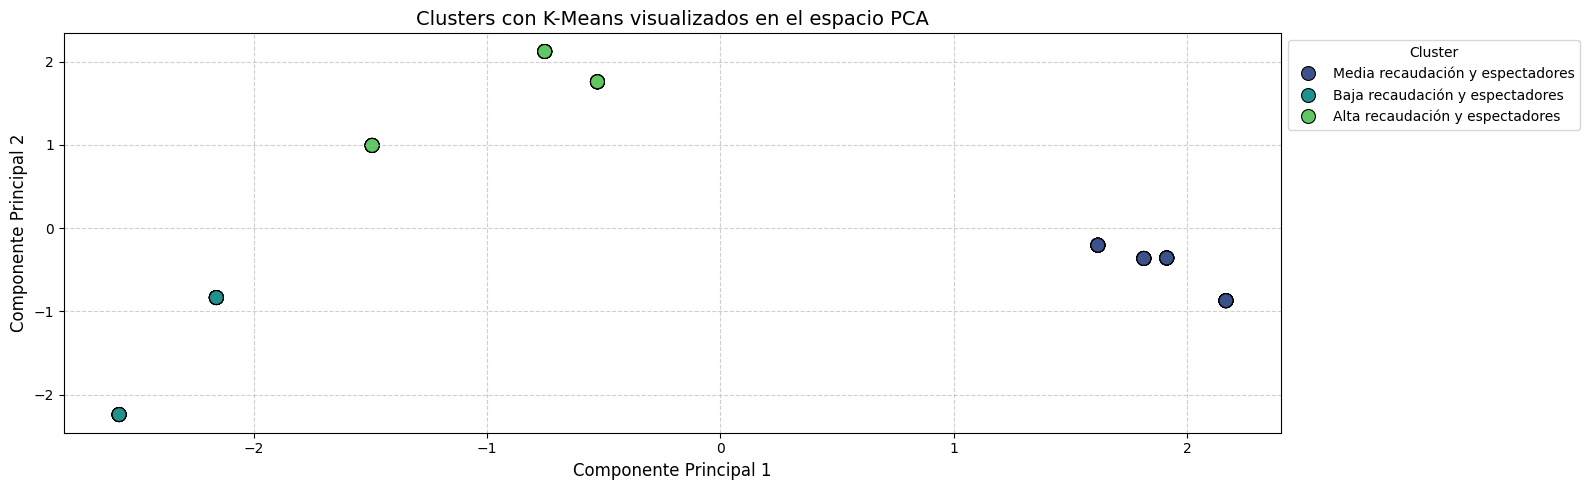

In [52]:
# --------------------
# Clustering: K-Means 
# --------------------

# Configurar hiperparámetros 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
clusters_kmeans = kmeans.fit_predict(X_clust_scaled)

# Métricas de evaluación
print("K-Means Inercia (SSE):", kmeans.inertia_)
try:
    silhouette_kmeans = silhouette_score(X_clust_scaled, clusters_kmeans)
    print("K-Means Silhouette Score:", silhouette_kmeans)
except Exception as e:
    print("No se pudo calcular el Silhouette Score para K-Means:", e)

# Asignar etiquetas 
cluster_labels = {
    0: "Alta recaudación y espectadores",
    1: "Media recaudación y espectadores",
    2: "Baja recaudación y espectadores"
}
df['Cluster_KMeans'] = [cluster_labels[label] for label in clusters_kmeans]

# Visualización de Clusters 
plt.figure(figsize=(16, 5))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], 
    hue=df['Cluster_KMeans'], palette="viridis", s=100, edgecolor='k'
)
plt.title("Clusters con K-Means visualizados en el espacio PCA", fontsize=14)
plt.xlabel("Componente Principal 1", fontsize=12)
plt.ylabel("Componente Principal 2", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.00, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [53]:
# --------------------------
# Análisis de Clasificación 
# --------------------------

# Definir características 
features_clf = ['Edad', 'Nº de personas', 'Gasto medio/espectador', 'Frecuencia',
                'Género Acción', 'Género Comedia', 'Género Drama', 'Género Terror']
X_clf = df[features_clf]
y_clf = df['Cluster_KMeans']  

# Dividir en conjuntos de entrenamiento y prueba (80%/20%)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42)

# Mostrar las dimensiones de los conjuntos 
print("Dimensiones de los conjuntos de clasificación:")
print(f"Entrenamiento: {X_train_clf.shape} | Prueba: {X_test_clf.shape}")

# Crear preprocesador para escalar las variables numéricas
preprocessor_clf = ColumnTransformer(
    transformers=[('num', StandardScaler(), features_clf)], remainder='passthrough'
)

# Aplicar el preprocesador a los datos de entrenamiento y prueba
X_train_clf_scaled = preprocessor_clf.fit_transform(X_train_clf)
X_test_clf_scaled = preprocessor_clf.transform(X_test_clf)

print("Preprocesador configurado correctamente y los datos están escalados.")

Dimensiones de los conjuntos de clasificación:
Entrenamiento: (72, 8) | Prueba: (18, 8)
Preprocesador configurado correctamente y los datos están escalados.


Decision Tree Classifier:
Accuracy: 1.0
Classification Report:
                                   precision    recall  f1-score   support

 Alta recaudación y espectadores       1.00      1.00      1.00         4
 Baja recaudación y espectadores       1.00      1.00      1.00         4
Media recaudación y espectadores       1.00      1.00      1.00        10

                        accuracy                           1.00        18
                       macro avg       1.00      1.00      1.00        18
                    weighted avg       1.00      1.00      1.00        18



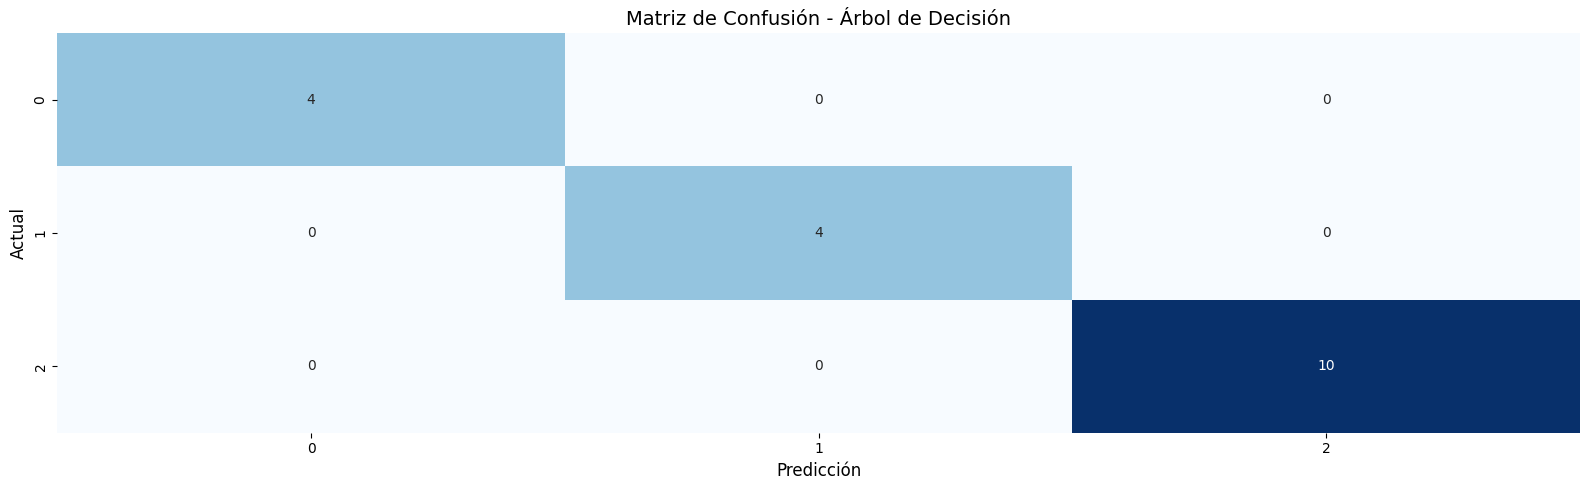

Decision Tree Classifier - Precisión promedio (Validación cruzada): 1.0
Desviación estándar de precisión: 0.0000


In [54]:
# ----------------------------
# Pipeline: Arbol de Decisión
# ----------------------------

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_clf),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_pipeline.fit(X_train_clf, y_train_clf)
y_pred_dt = dt_pipeline.predict(X_test_clf)

print("Decision Tree Classifier:")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_dt))
print("Classification Report:\n", classification_report(y_test_clf, y_pred_dt))

# Visualización de la Matriz de Confusión
plt.figure(figsize=(16, 5))
sns.heatmap(confusion_matrix(y_test_clf, y_pred_dt), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión - Árbol de Decisión", fontsize=14)
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# Validación cruzada para Árbol de Decisión
cv_scores_dt = cross_val_score(dt_pipeline, X_clf, y_clf, cv=5, scoring='accuracy')
mean_accuracy_dt = np.mean(cv_scores_dt)
std_accuracy_dt = np.std(cv_scores_dt)
print("Decision Tree Classifier - Precisión promedio (Validación cruzada):", mean_accuracy_dt)
print(f"Desviación estándar de precisión: {std_accuracy_dt:.4f}")

SVM Classifier Accuracy: 0.9444444444444444
Classification Report:                                   precision    recall  f1-score   support

 Alta recaudación y espectadores       0.80      1.00      0.89         4
 Baja recaudación y espectadores       1.00      0.75      0.86         4
Media recaudación y espectadores       1.00      1.00      1.00        10

                        accuracy                           0.94        18
                       macro avg       0.93      0.92      0.92        18
                    weighted avg       0.96      0.94      0.94        18



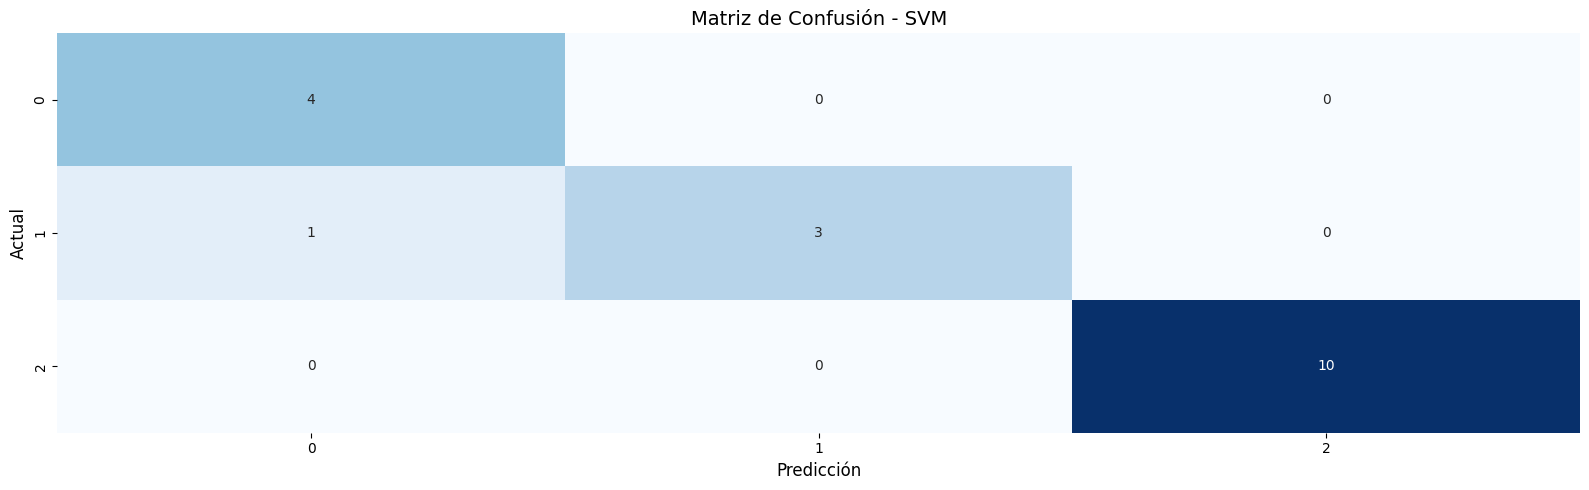

SVM Classifier - Precisión promedio (Validación cruzada): 0.9888888888888889
Desviación estándar de precisión: 0.0222


In [55]:
# -------------------------------------
# Pipeline: Support Vector Machine SVM
# -------------------------------------

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_clf),
    ('classifier', SVC(kernel='rbf', random_state=42, C=1.0, gamma='scale'))
])
svm_pipeline.fit(X_train_clf, y_train_clf)
y_pred_svm = svm_pipeline.predict(X_test_clf)

print("SVM Classifier Accuracy:", accuracy_score(y_test_clf, y_pred_svm))
print("Classification Report:", classification_report(y_test_clf, y_pred_svm))

# Visualización de la matriz de confusión
plt.figure(figsize=(16, 5))
sns.heatmap(confusion_matrix(y_test_clf, y_pred_svm), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión - SVM", fontsize=14)
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# Validación cruzada para SVM
cv_scores_svm = cross_val_score(svm_pipeline, X_clf, y_clf, cv=5, scoring='accuracy')
mean_accuracy_svm = np.mean(cv_scores_svm)
std_accuracy_svm = np.std(cv_scores_svm)
print("SVM Classifier - Precisión promedio (Validación cruzada):", mean_accuracy_svm)
print(f"Desviación estándar de precisión: {std_accuracy_svm:.4f}")

In [56]:
# ---------------
# Guardar joblib
# ---------------
# Guardamos el modelo de Random Forest para regresión
joblib.dump(rf_model, 'src/models/final_rf_model.pkl')
print("Modelo Random Forest Regression exportado en 'src/models/final_rf_model.pkl'")

# Guardamos el pipeline completo del Árbol de Decisión para clasificación
joblib.dump(dt_pipeline, 'src/models/final_decision_tree_classifier.pkl')
print("Modelo Decision Tree Classifier exportado en 'src/models/final_decision_tree_classifier.pkl'")


Modelo Random Forest Regression exportado en 'src/models/final_rf_model.pkl'
Modelo Decision Tree Classifier exportado en 'src/models/final_decision_tree_classifier.pkl'
